![](./figures/Logo.PNG)

## In this part of the tutorial, you will
* use the Morris sensitivity analysis method
* analyse the convergence of sensitivities

---

# 4 b - Sensitivity analysis using the Morris method

---

## 1. About the Morris method

The Morris method is a **computationally efficient** and well-established global sensitivity analysis (GSA). 
It starts with generating a set of random points in a defined parameter space, made up by the lower and upper bounds of each parameter. 
For these baseline points, the elementary effects (EEs) of each parameter $p_1 \dots p_n$ are received by **perturbing each parameter by a defined distance $\Delta$** and **calculating the finite difference in the output**.

This output is usually the result of some objective function (e.g., NSE).
- The **total effect of a parameter** is calculated as the **mean of the objective function over all EEs** ($\mu$) over the baseline points. 
A higher total effect means higher sensitivity towards the respective parameter. 

- A high **standard deviation of the total effect** ($\sigma$) indicates **high interaction between that parameter and other parameters**.

<center>
    <img src="https://uqpyproject.readthedocs.io/en/latest/_images/morris_indices.png"
        style="width:75%">
</center>

Owing to the low number of samples, the results can differ between individual runs of the Morris method. Multiple runs of the Morris method with new EEs, i.e. [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)), can be used to create confidence limits for parameter sensitivity.

For further information on the Morris method, check out [this publication](https://doi.org/10.5281/zenodo.6110623 )

## 2. Using the Morris method

In this notebook, you will apply the Morris method to screen and potentially rank HBV parameter sensitivity. 
In other words, you will assess, which parameters are important for the model output and which we might want to omit for following investigations of the studied catchment.

You will see that some parameters stand out while others are clustered, having similar standard deviation and mean of the EEs. We will use bootstrapping to get confidence limits for each parameter.

### 2.1 Preparations 

**Import python modules, define functions**

In [1]:
import sys
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from ipywidgets import interact_manual, Dropdown

sys.path.append("src")
import HBV, EET, plot_functions, sampling, util

# overwrite colors
plt.style.use('default')
plt.matplotlib.cm.jet = lambda _: ["#e6194B", "#3cb44b", "#4363d8", "#f58231", "#aaffc3", "#42d4f4", "#a9a9a9", "#ffe119", "#f032e6", "#fabed4", "#469990", "#9A6324", "#dcbeff"]

# supress numba warnings
logger = logging.getLogger("numba")
logger.setLevel(logging.ERROR)

def calc_nse(obs, sim):
    """
    Calculate the Nash-Sutcliffe Efficiency (NSE) coefficient for model performance.
    The NSE ranges from zero to one, with one being the optimal value.
    """
    r_nse = np.corrcoef(obs, sim)[0][1] 
    alpha_nse = np.divide(np.std(sim), np.std(obs))
    beta_nse = np.divide(np.subtract(np.mean(sim), np.mean(obs)), np.std(obs))
    nse = 2 * alpha_nse * r_nse - np.square(alpha_nse) - np.square(beta_nse)
    return nse

def hbv(par, precip, temp, evap):
    """
    Run the HBV model to simulate runoff using snow routine and runoff simulation.
    """
    p_s, _, _ = HBV.snow_routine(par[:4], temp, precip)
    Case = 1 # for now we assume that the preferred path in the upper zone is runoff (Case = 1), it can be set to percolation (Case = 2)
    ini = np.array([0,0,0]) # initial state
    runoff_sim, _, _ = HBV.hbv_sim(par[4:], p_s, evap, Case, ini)
    return runoff_sim

def hbv_and_one_obj_fun(par, precip, temp, evap, runoff_obs, n_days, obj_fun):
    """
    Run HBV model and evaluate it using a single objective function.
    """
    runoff_sim = hbv(par, precip, temp, evap)
    errors = obj_fun(runoff_obs[n_days:], runoff_sim[n_days:])
    return errors, runoff_sim[n_days:]

def load_catchment_data(file, startDate="2000", endDate="2005"):
    data = pd.read_csv(file, sep=r"\s+")
    # combine columns to create a datetime column
    data['DATE'] = pd.to_datetime(data[['YR', 'MNTH', 'DY']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')
    # set the new column as the index
    data = data.set_index('DATE')
    # keep only relevant variables
    data = data[["PRCP", "TAIR", "PET", "SWE", "OBS_RUN"]]
    # rename the columns
    data.columns = ["P", "T", "PET", "Snow", "Q_obs"]

    # subset range
    data = data.loc[(data.index >= startDate) & (data.index <= endDate)]
    return data

def sort_legend_by(order, **kwargs):

    # grab the legend handles and labels
    handles = plt.gca().legend_.legend_handles
    labels  = [label._text for label in plt.gca().legend_.texts]

    # sort both handles and labels
    handles = np.array(handles)[order]
    labels  = np.array(labels)[order]

    # set the handles of the legend
    plt.gca().legend(handles, labels, **kwargs)

plt.sort_legend_by = sort_legend_by

**Read catchment data, define parameter bounds**

In [2]:
dict_catchments = {
    "Medina River, TX, USA": "./data/08178880_medina_TX.txt",
    "Siltez River, OR, USA": "./data/14305500_siletz_OR.txt",
    "Dix River, KY, USA": "./data/03285000_dix_KY.txt",
    "Knife River, MN, USA": "./data/04015330_knife_MN.txt"
}
catchment_dropdown = Dropdown(options=dict_catchments.items())
display(catchment_dropdown)

Dropdown(options=(('Medina River, TX, USA', './data/08178880_medina_TX.txt'), ('Siltez River, OR, USA', './dat…

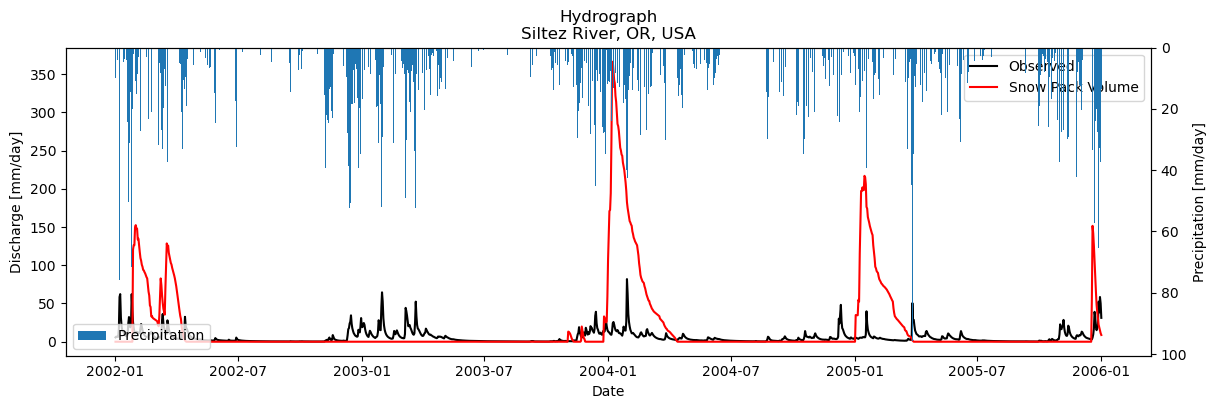

In [6]:
# load the catchment data
df = load_catchment_data(catchment_dropdown.value, '2002', '2006')
P, PET, T, Q_obs = df[['P', 'PET', 'T', 'Q_obs']].values.T

# number of spinup days before the evaluation period
n_spinup_days = 365

# define parameter names and bounds
param_names = np.array(["Ts"  , "CFMAX", "CFR", "CWH", "BETA", "LP", "FC", "PERC", "K0", "K1", "K2" , "UZL", "MAXBAS"])
lower       = np.array([-2.5  , 0.5    , 0    , 0    , 0     , 0.3 , 50  , 0     , 0.05, 0.01, 0.001, 0    , 1])
upper       = np.array([2.5   , 5      , 0.1  , 0.2  , 6     , 5   , 700 , 60    , 0.99, 0.8 , 0.15 , 250  , 3])
ranges      = np.stack([lower, upper], axis=1)
n_params    = len(param_names)

plt.figure(figsize=(14, 4))
plt.plot(df.index, Q_obs, color="black", label="Observed")
plt.plot(df.index, df.Snow, color="red", label="Snow Pack Volume")
plt.xlabel("Date")
plt.ylabel("Discharge [mm/day]")
plt.legend()
plt.twinx()
plt.bar(df.index, P, label="Precipitation", color="C0", linestyle="--")
plt.gca().invert_yaxis()
plt.ylabel("Precipitation [mm/day]")
plt.legend()
plt.title("Hydrograph\n" + list(dict_catchments.keys())[catchment_dropdown.index])
plt.show()

### 2.2 Applying the Morris method

In [4]:
@interact_manual.options(manual_name="Run Morris Analysis")(n_EEs = (10, 200, 10))
def plot_simple_morris(n_EEs=50):

    # create samples for Morris method
    # "LHS" is the sampling stategy, e.g. latin hypercube sampling
    # "radial" is the design type of the trajectories TODO: why use a radial design type and not the trajectory?
    np.random.seed(42)
    samples = sampling.OAT_sampling(n_EEs, n_params, sp.stats.uniform, np.transpose([lower, upper - lower]).tolist(), "lhs", "radial")

    # run hbv for each parameter set and calculate the nse
    print(f"Number of model runs = {n_EEs} * ({n_params} + 1) = {samples.shape[0]}. This may take a while.\n")
    errors = np.zeros((samples.shape[0]))
    for i, parameter_set in enumerate(samples):
        errors[i], _ = hbv_and_one_obj_fun(parameter_set, P, T, PET, Q_obs, n_spinup_days, calc_nse)

    # compute the elementary effects
    mi, sg, _ = EET.EET_indices(n_EEs, lower.tolist(), upper.tolist(), samples, errors, "radial")

    # plot results in the plane (mean(EE), std(EE))
    EET.EET_plot(mi, sg, param_names.tolist())
    plt.title("Morris Parameter Importance\n" + list(dict_catchments.keys())[catchment_dropdown.index])
    plt.sort_legend_by(np.argsort(-mi), loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

    # print overview of results
    df_res = pd.DataFrame(np.array([param_names, mi, sg]).T, columns=["Parameters", "Mean of EEs (x-axis)", "Standard deviation of EEs (y-axis)"])
    df_res["Mean of EEs (x-axis)"] = df_res["Mean of EEs (x-axis)"].astype(float).round(4)
    df_res["Standard deviation of EEs (y-axis)"] = df_res["Standard deviation of EEs (y-axis)"].astype(float).round(4)
    display(df_res.sort_values("Mean of EEs (x-axis)", ascending=False))

interactive(children=(IntSlider(value=50, description='n_EEs', max=200, min=10, step=10), Button(description='…

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Task I: Understanding Morris' Method</h4>
    <ol>
        <li>Based on the Morris analysis: Which paramters are important? Which show strong interactions? Which are noninfluencial?</li>
        <li>Increase the number of elementary effects. Why do mean and standard deviation of the elementary effects change? What is the consequence of this variability?</li>
    </ol>
</div>

_DOUBLE CLICK TO ANSWER HERE_

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black"></div>

**Use bootstrapping to derive confidence bounds**

In [5]:
@interact_manual.options(manual_name="Run Convergence Analysis")(n_bootstraps = (100, 500, 10), n_EEs = (10, 200, 10))
def plot_morris_convergence(n_bootstraps = 100, n_EEs = 50):

    # create samples for Morris method
    # "LHS" is the sampling stategy, e.g. latin hypercube sampling
    # "radial" is the design type of the trajectories TODO: why use a radial design type and not the trajectory?
    np.random.seed(42)
    samples = sampling.OAT_sampling(n_EEs, n_params, sp.stats.uniform, np.transpose([lower, upper - lower]).tolist(), "lhs", "radial")

    # run hbv for each parameter set and calculate the nse
    print(f"Number of model runs = {n_EEs} * ({n_params} + 1) = {samples.shape[0]}. This may take a while.\n")
    errors = np.zeros((samples.shape[0]))
    for i, parameter_set in enumerate(samples):
        errors[i], _ = hbv_and_one_obj_fun(parameter_set, P, T, PET, Q_obs, n_spinup_days, calc_nse)

    # compute the elementary effects
    mi, sg, EE = EET.EET_indices(n_EEs, lower.tolist(), upper.tolist(), samples, errors, "radial", n_bootstraps)
    # compute mean and confidence intervals of the sensitivity indices across the bootstrap resamples
    mi_mean, mi_lower, mi_upper = util.aggregate_boot(mi)
    sg_mean, sg_lower, sg_upper = util.aggregate_boot(sg)

    # order of the mean of the elementary effects
    order = np.argsort(-mi_mean)
    
    # plot results in the plane (mean(EE), std(EE))
    EET.EET_plot(mi_mean, sg_mean, param_names.tolist(), mi_lower, mi_upper, sg_lower, sg_upper)
    plt.title("Morris Parameter Importance\n" + list(dict_catchments.keys())[catchment_dropdown.index])
    plt.sort_legend_by(order, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

    # repeat computations using a decreasing number of samples so as to assess
    # if convergence was reached within the available dataset
    n_EEs_convergence = np.linspace(n_EEs/10, n_EEs, 10).astype(int)
    # compute the sensitivit indices again, now for different numbers of elementary effects
    mi, sg = EET.EET_convergence(EE, n_EEs_convergence, n_bootstraps)
    # compute mean and confidence intervals of the sensitivity indices across the bootstrap resamples
    mi_mean, mi_lower, mi_upper = util.aggregate_boot(mi)
    sg_mean, sg_lower, sg_upper = util.aggregate_boot(sg)

    # plot the sensitivity measure (mean of elementary effects) as a function of the number of model evaluations:
    plot_functions.plot_convergence(mi_mean, n_EEs_convergence * (n_params + 1), X_Label='no of model evaluations', Y_Label='mean of EEs', labelinput=param_names.tolist())
    plt.title("Convergence of Mean\n" + list(dict_catchments.keys())[catchment_dropdown.index])
    plt.sort_legend_by(order, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

    # plot the sensitivity measure (standard deviation of elementary effects) as a function of the number of model evaluations:
    plot_functions.plot_convergence(sg_mean, n_EEs_convergence * (n_params + 1), X_Label='no of model evaluations', Y_Label='std of EEs', labelinput=param_names.tolist())
    plt.title("Convergence of Standard Deviation\n" + list(dict_catchments.keys())[catchment_dropdown.index])
    plt.sort_legend_by(order, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

    # print overview of results
    df_res = pd.DataFrame(np.vstack([param_names, mi_mean[-1], sg_mean[-1]]).T, columns=["Parameters", "Mean of EEs (x-axis)", "Standard deviation of EEs (y-axis)"])
    df_res["Mean of EEs (x-axis)"] = df_res["Mean of EEs (x-axis)"].astype(float).round(4)
    df_res["Standard deviation of EEs (y-axis)"] = df_res["Standard deviation of EEs (y-axis)"].astype(float).round(4)
    display(df_res.sort_values("Mean of EEs (x-axis)", ascending=False))

interactive(children=(IntSlider(value=100, description='n_bootstraps', max=500, min=100, step=10), IntSlider(v…

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black">
    <h4><span>&#129300 </span>Your Turn II: Bootstrapping</h4>
    <ol>
        <li>What do the colored rectangles in the first plot represent? How does this influence your ranking of paramter importance?</li>
        <li>What parameter is most important? What parameter shows the largest interactions?</li>
        <li>At what point have you reached a convergence in sensitivity?</li>
    </ol>
</div>

_DOUBLE CLICK TO ANSWER HERE_

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue; color:black"></div>